In [1]:
# ============================================================
# Employee Attrition Project - Notebook 03
# 03_feature_engineering_and_shap.ipynb
# Purpose:
#   - Load processed train/test data from Notebook 2
#   - Perform optional feature engineering
#   - Train baseline RandomForest model
#   - Build SHAP-ready explainability pipeline
# ============================================================

# -------------------------
# 1. Imports
# -------------------------
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib
import shap


c:\Users\kakinwande1\AppData\Local\miniconda3\envs\employee_attrition\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -------------------------
# 2. Paths
# -------------------------
project_root = r"C:\Users\kakinwande1\Employee_atrttion"
processed_folder = os.path.join(project_root, "data", "processed")
models_folder = os.path.join(project_root, "models")
os.makedirs(models_folder, exist_ok=True)

train_path = os.path.join(processed_folder, "train.csv")
test_path = os.path.join(processed_folder, "test.csv")
y_train_path = os.path.join(processed_folder, "y_train.csv")
y_test_path = os.path.join(processed_folder, "y_test.csv")

In [3]:
# -------------------------
# 3. Load Processed Data
# -------------------------
X_train = pd.read_csv(train_path)
X_test = pd.read_csv(test_path)
y_train = pd.read_csv(y_train_path).squeeze()
y_test = pd.read_csv(y_test_path).squeeze()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Target distribution (train):\n{y_train.value_counts(normalize=True)}")

Train shape: (1176, 55), Test shape: (294, 55)
Target distribution (train):
Attrition
0    0.838435
1    0.161565
Name: proportion, dtype: float64


In [4]:
# -------------------------
# 4. Optional Feature Engineering
# -------------------------
if "YearsAtCompany" in X_train.columns and "JobLevel" in X_train.columns:
    X_train["Tenure_per_Level"] = X_train["YearsAtCompany"] / (X_train["JobLevel"] + 1)
    X_test["Tenure_per_Level"] = X_test["YearsAtCompany"] / (X_test["JobLevel"] + 1)

print("Feature engineering complete.")

Feature engineering complete.


In [5]:
# -------------------------
# 5. Train Baseline Model
# -------------------------
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


In [6]:
# -------------------------
# 6. Save Model
# -------------------------
model_path = os.path.join(models_folder, "employee_attrition_rf.pkl")
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

Model saved to: C:\Users\kakinwande1\Employee_atrttion\models\employee_attrition_rf.pkl


In [7]:
# -------------------------
# 7. SHAP Explainability Setup
# -------------------------
shap.initjs()
explainer = shap.TreeExplainer(model)

print("Computing SHAP values (this may take a moment)...")
shap_values = explainer.shap_values(X_test)

Computing SHAP values (this may take a moment)...


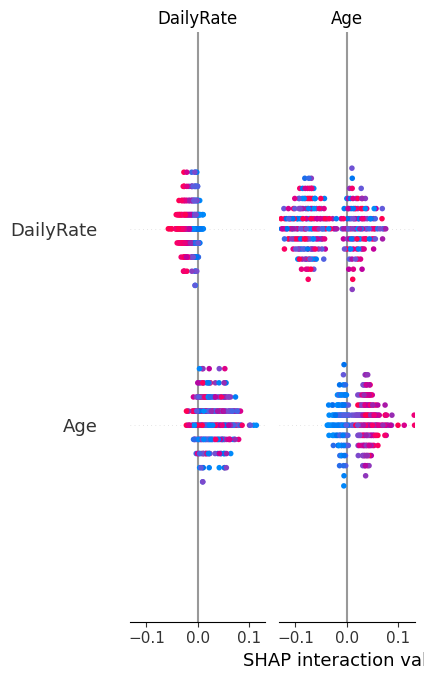

In [8]:
# -------------------------
# 8. SHAP Global Feature Importance
# -------------------------
if isinstance(shap_values, list):
    sv = shap_values[1]  # class 1 (Attrition=Yes)
else:
    sv = shap_values
shap.summary_plot(sv, X_test, plot_type="bar")

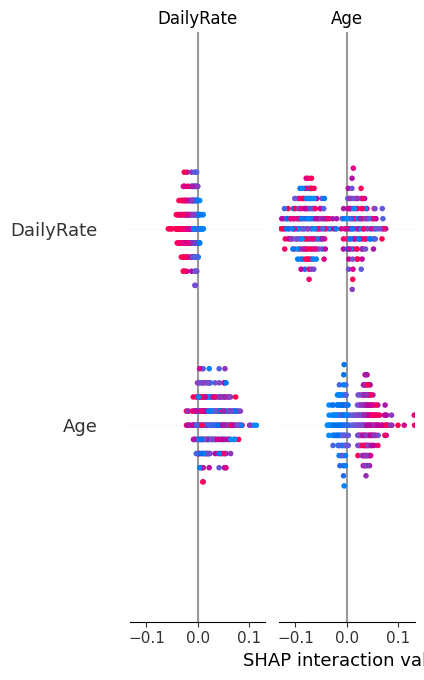

In [9]:

# -------------------------
# 9. SHAP Detailed Summary Plot
# -------------------------
shap.summary_plot(sv, X_test)